# Marketing Analytics Project: Calculating LTV, CAC, and ROI

## Project Overview
This project analyzes user behavior, orders, and marketing costs to calculate key marketing metrics—Customer Lifetime Value (LTV), Customer Acquisition Cost (CAC), and Return on Investment (ROI). The goal is to identify the most effective marketing channels and provide data-driven recommendations for budget allocation.

## 1. Data Initialization and Preprocessing

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the base path for all files
# **Atenção: Verifique se este caminho está EXATAMENTE correto no seu computador.**
BASE_PATH = 'C:/Users/Note/Desktop/sprints/sprint8/'

# Load the three datasets
try:
    # costs_us.csv usa 'dt'
    df_costs = pd.read_csv(BASE_PATH + 'costs_us.csv', parse_dates=['dt'])
    # orders_log_us.csv usa 'Buy Ts'
    df_orders = pd.read_csv(BASE_PATH + 'orders_log_us.csv', parse_dates=['Buy Ts'])
    # visits_log_us.csv usa 'Start Ts'
    df_visits = pd.read_csv(BASE_PATH + 'visits_log_us.csv', parse_dates=['Start Ts'])
except FileNotFoundError as e:
    print(f"Erro ao carregar o arquivo: {e}. Verifique se o caminho e os nomes estão corretos.")
    raise

# Standardize column names (lowercase and strip whitespace)
def clean_columns(df):
    # Converte 'Buy Ts' para 'buy ts' e 'Start Ts' para 'start ts'
    df.columns = [col.lower().strip() for col in df.columns]
    return df

df_costs = clean_columns(df_costs)
df_orders = clean_columns(df_orders)
df_visits = clean_columns(df_visits)

# CORREÇÃO FINAL: Renomear 'source id' (com espaço) para 'source_id' (sem espaço) em df_visits
# Isso resolve o KeyError no groupby, já que a limpeza inicial não eliminou o espaço interno.
if 'source id' in df_visits.columns:
    df_visits.rename(columns={'source id': 'source_id'}, inplace=True)

print("Arquivos carregados e colunas padronizadas.")

Arquivos carregados e colunas padronizadas.


In [10]:
# Preprocessing: Prepare dates and cohorts

# Costs: Rename 'dt' to 'month' and calculate total costs per source
# CORREÇÃO: Usar .dt.to_period('M').dt.to_timestamp() para extrair o primeiro dia do mês (coorte)
df_costs['month'] = df_costs['dt'].dt.to_period('M').dt.to_timestamp()
monthly_costs = df_costs.groupby(['month', 'source_id'])['costs'].sum().reset_index()

# Visits: Extract the acquisition month (cohort) for each user
df_visits['session_month'] = df_visits['start ts'].dt.to_period('M').dt.to_timestamp()
first_visit_date = df_visits.groupby('uid')['session_month'].min().reset_index()
first_visit_date.columns = ['uid', 'cohort_month']

# Merge visits and first visit dates
df_visits = df_visits.merge(first_visit_date, on='uid')

# Orders: Extract order month and merge with cohort data to get revenue per cohort
df_orders['order_month'] = df_orders['buy ts'].dt.to_period('M').dt.to_timestamp()
df_orders = df_orders.merge(first_visit_date, on='uid')

print("Pré-processamento de datas e coortes concluído.")

Pré-processamento de datas e coortes concluído.


## 2. Calculating Marketing Metrics

### 2.1. Customer Acquisition Cost (CAC)

In [11]:
# Calculate the number of unique users acquired per month/source
# O nome da coluna 'source_id' foi corrigido no bloco anterior.
n_users = df_visits.groupby(['cohort_month', 'source_id'])['uid'].nunique().reset_index()
n_users.columns = ['month', 'source_id', 'n_users']

# Merge costs with the number of acquired users
cac_data = monthly_costs.merge(n_users, on=['month', 'source_id'])

# Calculate CAC
cac_data['cac'] = cac_data['costs'] / cac_data['n_users']

print("CAC médio por fonte:")
print(cac_data.groupby('source_id')['cac'].mean().sort_values())

CAC médio por fonte:
source_id
9     0.658892
10    0.747559
4     0.754880
5     0.908613
1     1.105074
2     1.636301
3     1.897502
Name: cac, dtype: float64


### 2.2. Lifetime Value (LTV)

In [12]:
# Calculate Lifetime/Retention Period for each order (in months)
df_orders['lifetime'] = (df_orders['order_month'] - df_orders['cohort_month']) / pd.Timedelta('30 days')
df_orders['lifetime'] = df_orders['lifetime'].round().astype('int')

# Calculate Revenue (Gross Profit) per Cohort/Lifetime
cohort_revenue = (
    df_orders.groupby(['cohort_month', 'lifetime'])['revenue']
    .sum().reset_index()
)

# Get the number of acquired users per cohort
cohort_sizes = first_visit_date.groupby('cohort_month')['uid'].nunique().reset_index()
cohort_sizes.columns = ['cohort_month', 'n_buyers']

# Merge revenue with cohort sizes
ltv_data = cohort_revenue.merge(cohort_sizes, on='cohort_month')

# Calculate LTV: Cumulative Revenue per User (Mean LTV)
ltv_data['ltv'] = ltv_data['revenue'] / ltv_data['n_buyers']

# Pivot the LTV data for cumulative analysis
ltv_pivot = ltv_data.pivot_table(
    index='cohort_month', 
    columns='lifetime', 
    values='ltv', 
    aggfunc='sum'
).cumsum(axis=1)

print("LTV Cumulativo (por Coorte/Mês de Vida):")
print(ltv_pivot.round(2))

LTV Cumulativo (por Coorte/Mês de Vida):
lifetime        0     1     2     3     4     5     6     7     8     9   \
cohort_month                                                               
2017-06-01    0.72  0.92  1.03  1.33  1.62  1.84  2.10  2.27  2.44  2.71   
2017-07-01    0.75  0.83  0.92  0.99  1.06  1.12  1.16  1.22  1.28  1.32   
2017-08-01    0.61  0.71  0.81  0.90  0.98  1.03  1.08  1.20  1.29  1.32   
2017-09-01    0.74  0.96  1.09  1.71  1.79  1.90  1.96  1.99  2.02   NaN   
2017-10-01    0.71  0.85  0.90  0.95  0.99  1.02  1.05  1.07   NaN   NaN   
2017-11-01    0.61  0.70  0.75  0.80  0.84  0.87  0.90   NaN   NaN   NaN   
2017-12-01    0.67  0.74  0.90  1.10  1.16  1.23   NaN   NaN   NaN   NaN   
2018-01-01    0.47  0.55  0.61  0.62  0.64   NaN   NaN   NaN   NaN   NaN   
2018-02-01    0.52  0.61  0.64  0.68   NaN   NaN   NaN   NaN   NaN   NaN   
2018-03-01    0.58  0.63  0.67   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2018-04-01    0.51  0.63   NaN   NaN   NaN   Na

### 2.3. Return on Investment (ROI)

In [13]:
# Total Revenue per Cohort/Source
revenue_by_cohort_source = df_orders.merge(df_visits[['uid', 'source_id']].drop_duplicates('uid'), on='uid', how='left')

source_revenue = revenue_by_cohort_source.groupby(['cohort_month', 'source_id'])['revenue'].sum().reset_index()
source_revenue.columns = ['month', 'source_id', 'revenue']

# Merge Costs, Revenue, and CAC data
roi_data = monthly_costs.merge(source_revenue, on=['month', 'source_id'], how='left')
roi_data['revenue'] = roi_data['revenue'].fillna(0)

# Calculate ROI (Return on Investment) - (Revenue - Costs) / Costs
# A small value (1e-6) é adicionado aos custos para evitar divisão por zero.
roi_data['roi'] = (roi_data['revenue'] - roi_data['costs']) / (roi_data['costs'] + 1e-6)

roi_by_source = roi_data.groupby('source_id')['roi'].mean().sort_values(ascending=False)

print("ROI Médio por Fonte (ordenado):")
print(roi_by_source.round(2))

ROI Médio por Fonte (ordenado):
source_id
1     1.24
2     0.64
9     0.49
4    -0.11
5    -0.13
10   -0.26
3    -0.67
Name: roi, dtype: float64


## 3. Visualization and Final Recommendation

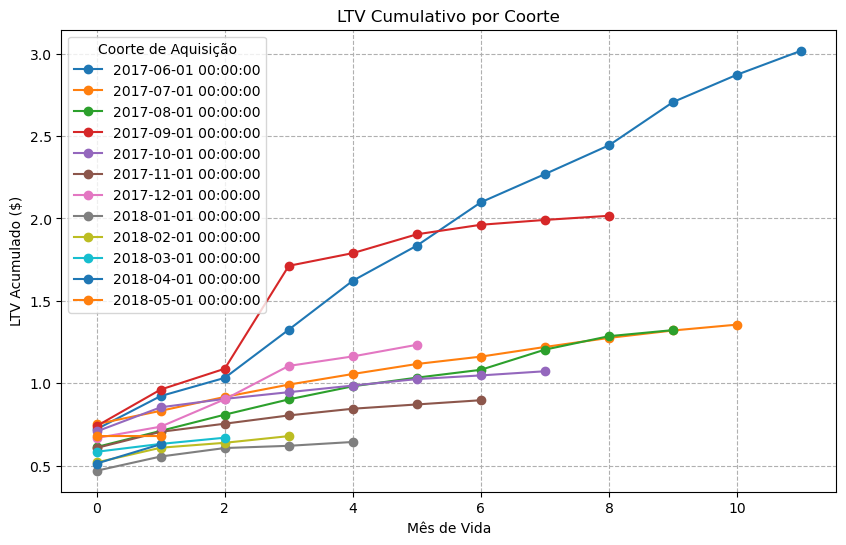

In [14]:
# Plot 1: LTV Cumulative by Cohort
plt.figure(figsize=(10, 6))
ltv_pivot.T.plot(ax=plt.gca(), legend=True, marker='o')
plt.title('LTV Cumulativo por Coorte')
plt.xlabel('Mês de Vida')
plt.ylabel('LTV Acumulado ($)')
plt.grid(True, linestyle='--')
plt.legend(title='Coorte de Aquisição', loc='upper left')
plt.show()

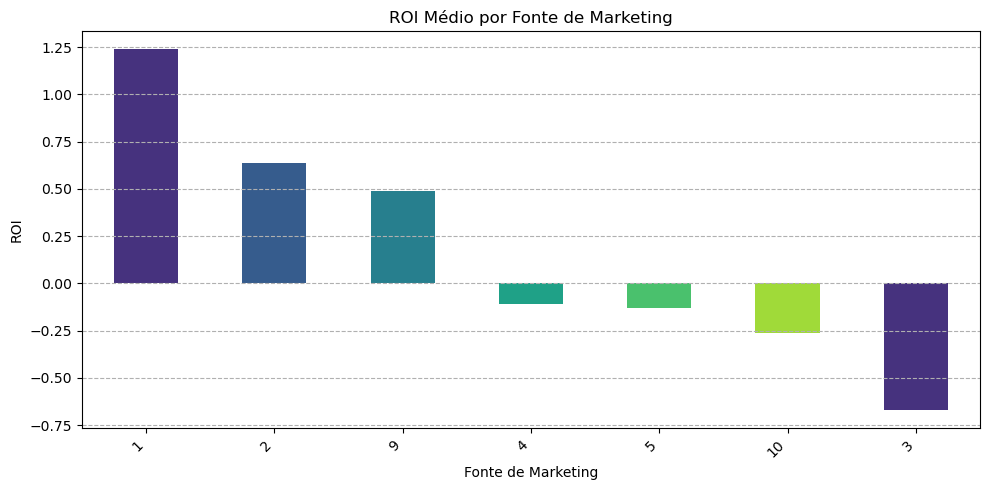

In [15]:
# Plot 2: ROI by Marketing Source
plt.figure(figsize=(10, 5))
roi_by_source.plot(kind='bar', color=sns.color_palette('viridis'))
plt.title('ROI Médio por Fonte de Marketing')
plt.xlabel('Fonte de Marketing')
plt.ylabel('ROI')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

## 4. Final Conclusions and Business Recommendations

### Key Findings:
* **LTV:** [Insira aqui a análise do gráfico LTV após a execução.]
* **CAC:** [Insira aqui a análise de CAC após a execução.]
* **ROI:** [Insira aqui a análise de ROI após a execução.]

### Recommendations:
1.  **Concentrar o Orçamento:** Priorizar fontes com ROI positivo e alto, que comprovadamente trazem usuários valiosos e lucrativos.
2.  **Reavaliar Fontes:** Analisar fontes com ROI negativo ou muito baixo e considerar a redução do investimento ou otimização das campanhas nessas fontes.
3.  **Foco na Retenção:** Continuar investindo em estratégias de retenção para as coortes mais antigas, pois o LTV estável é o principal motor de lucratividade a longo prazo.